## Obtain spectra for the sources and add additional spec-zs from SIMBAD

In [2]:
%matplotlib inline
import sys, os, glob, copy

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read the HSC-SSP AGN table

https://ui.adsabs.harvard.edu/abs/2020ApJ...894...24K/abstract

In [66]:
# Read HSC-SSP AGNs
data_agn = ascii.read('hsc_agn.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')
# data_agn

1: spectroscopic redshift from the HSC catalog,

2: spectroscopic redshift from the DEIMOS catalog,

3: photometric redshift from z_best in the Chandra catalog,

4: photometric redshift from ZPDF in the COSMOS2015 catalog.

There are still more with spectra than it appears this table!

Prepare the updated table by copying and adding extra columns 
Only keep DRIMOS (r_z=2) since r_z=1 is DR2 and r_z=3&1 is phot-z

In [129]:
data_agn_updated = data_agn['ID', 'RAdeg', 'DEdeg']
data_agn_updated['z_old'] = data_agn['z']
data_agn_updated['r_z_old'] = data_agn['r_z']
data_agn_updated['z'] = -1.
data_agn_updated['r_z'] = -1

data_agn_updated['z2'] = -1. 
for i in range(len(data_agn)): 
    if data_agn['r_z'][i]==2: 
        data_agn_updated['z2'][i] = data_agn['z'][i]

data_agn_updated.meta['comments'] = [
    'r_z   bibcode             description', 
    '1_old 2020ApJ...894...24K HSC-DR2 ', 
    '2_old 2018ApJ...858...77H DEIMOS', 
    '3_old 2016ApJ...817...34M Chandra-photz', 
    '4_old 2016ApJS..224...24L COSMOS2015-photz', 
    '0     see-z0_ref          SIMBAD', 
    '1     see-z1_ref          HSC DR3', 
]

data_agn_updated

ID,RAdeg,DEdeg,z_old,r_z_old,z,r_z,z2
--,deg,deg,--,--,,,
int64,float64,float64,float64,int64,float64,int64,float64
1,150.74386,2.20245,1.561,3,-1.0,-1,-1.0
2,150.73557,2.19957,3.499,1,-1.0,-1,-1.0
3,150.73353,2.15646,0.977,1,-1.0,-1,-1.0
4,150.79702,2.13888,0.573,1,-1.0,-1,-1.0
5,150.78259,2.19306,0.585,1,-1.0,-1,-1.0
6,150.72019,2.24803,0.664,1,-1.0,-1,-1.0
7,150.78838,2.34399,1.964,1,-1.0,-1,-1.0
8,150.71511,2.48483,1.999,1,-1.0,-1,-1.0


### Match to HSC PDR3 

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

inquiry website: https://hsc-release.mtk.nao.ac.jp/datasearch/

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source description: https://hsc-release.mtk.nao.ac.jp/doc/index.php/catalog-of-spectroscopic-redshifts__pdr3/

#### Obtain the HSC data and see what database it comes from

We first download all the spectra in cosmos field and then filter them using python. HSC catalog uses `SQL` to inquire about the redshift, which is not suitable for mass and fuzzy inquiry. 

```sql

SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift
      , specz_duplicationflag

      , specz_flag_zcosmos_bright_dr3
      , specz_flag_3dhst_v4_1_5
      , specz_flag_sdss_dr15
      , specz_flag_gama_dr3
      , specz_flag_udsz_dr1
      , specz_flag_vandels_dr2
      , specz_flag_c3r2_dr2
      , specz_flag_vvds_drfinal
      , specz_flag_deimos_2018
      , specz_flag_fmos_dr2
      , specz_flag_lega_c_dr2
      , specz_flag_primus_dr1
      , specz_flag_vipers_dr2
      , specz_flag_wigglez_dr1
      , specz_flag_deep23_dr4_egs

    FROM pdr3_dud_rev.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;

```

It will return a `csv` file that contains all the spec-z in COSMOS field. I have renamed it to `hsc-spec-cosmos.txt`

In [99]:
data_coords = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit=u.deg)
print(len(data_coords))

source_keys = ['specz_flag_zcosmos_bright_dr3', 'specz_flag_3dhst_v4_1_5', 'specz_flag_sdss_dr15', 'specz_flag_gama_dr3', 'specz_flag_udsz_dr1', 'specz_flag_vandels_dr2', 'specz_flag_c3r2_dr2', 'specz_flag_vvds_drfinal', 'specz_flag_deimos_2018', 'specz_flag_fmos_dr2', 'specz_flag_lega_c_dr2', 'specz_flag_primus_dr1', 'specz_flag_vipers_dr2', 'specz_flag_wigglez_dr1', 'specz_flag_deep23_dr4_egs']
hsc_targets = ascii.read('hsc-spec-cosmos.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])
hsc_duplication_mask = hsc_targets['specz_duplicationflag']==10

idx_hsc_pdr3, idx_hsc_specz, d2d, d3d = data_coords.search_around_sky(hsc_coords, 0.5*u.arcsec)
# Index to mask


print(len(hsc_targets[idx_hsc_pdr3]))
# plt.hist(d2d.to(u.arcsec).value, bins=100);

491
379


Fill in the updated table

In [ ]:
data_agn_updated['z1'] = -1.
data_agn_updated['z1_ref'] = None

for j,i in enumerate(idx_hsc_specz):
    data_agn_updated['z1'][i] = hsc_targets['specz_redshift'][idx_hsc_pdr3[j]]
    source_key = [key for key in source_keys if hsc_targets[i][key]==True][0][11:]
    data_agn_updated['z1_ref'][i] = source_key

### Match to SIMBAD using `astroquery`

Description for `add_votable_fields` refers to:  
https://github.com/astropy/astroquery/blob/main/astroquery/simbad/data/votable_fields_dict.json

In [ ]:
from astroquery.simbad import Simbad

# Add the redshift information
customSimbad = Simbad()
customSimbad.add_votable_fields('rvz_qual','rvz_wavelength','z_value', 'rvz_bibcode', 'flux(i)')

result_table = customSimbad.query_region(cat_agn, radius=0.5*u.arcsec)

# Sources with RVZ_WAVELENGTH == 'O' and rvz_qual!='E' should have an optical spectrum
print(len(result_table[result_table['RVZ_WAVELENGTH']=='O'])) 

mask_spec_simbad = (result_table['RVZ_WAVELENGTH']=='O') & (result_table['RVZ_QUAL']!='E') 

result_table.write('result_table.txt', format='csv', overwrite=True)

313


/home/chisen/anaconda3/envs/py39-wsl2/lib/python3.9/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 89 raised an error (recorded in the `errors` attribute of the result table): '10:01:58.956 +2:24:45.216': No astronomical object found :  
  warnings.warn("Warning: The script line number %i raised "


add result into updated table

In [144]:
data_agn_updated['z0'] = -1.
data_agn_updated['z0_ref'] = None

idx = result_table['SCRIPT_NUMBER_ID'].data.data - 1
idx_simbad_specz = idx[mask_spec_simbad]

for j,i in enumerate(idx_simbad_specz):
    data_agn_updated['z0'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_updated['z0_ref'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]

### Match to COSMOS2020 and Chandra COSMOS Legacy to get photometry and photo-z

#### COSMOS2020

https://cosmos2020.calet.org/catalogues/

Format : https://cosmos2020.calet.org/catalogues/COSMOS2020_DR4_1_1.pdf

In [136]:
# Follows
# https://github.com/cosmic-dawn/cosmos2020-readcat/blob/main/COSMOS2020_readcat.ipynb

# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'

# Point to the directory
dir_in = './'  
dir_out = './'  # the directory where the output of this notebook will be stored

# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'uJy' # 'cgs' or 'uJy'

# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['CHANDRA','GALEX_FUV','GALEX_NUV','CFHT_u','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [2.07e-4, 0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [3.1e-4,0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

In [137]:
# Read
data_cosmos2020 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.2_p3.fits'.format(catversion.upper()),format='fits',hdu=1)

# Create a mask to restrict the analysis to a subset of filters (optional)
# 'CHANDRA'
filt_use = ['CHANDRA','GALEX_FUV','GALEX_NUV','CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']
filt_mask = [i in filt_use for i in filt_name]

whichflag = 'COMBINED'  # you can try HSC, SUPCAM, UVISTA, UDEEP, COMBINED
print('The parent sample includes {} sources'.format(len(data_cosmos2020)))
#data_cosmos2020 = data_cosmos2020[data_cosmos2020['FLAG_{}'.format(whichflag)]==0]
#print('Now restricted to {} sources by using FLAG_COMBINED'.format(len(data_cosmos2020)))

The parent sample includes 964506 sources


#### Chandra COSMOS Legacy

Download `table5.dat` from https://cdsarc.cds.unistra.fr/ftp/cats/J/ApJ/819/62/

Format: https://cdsarc.cds.unistra.fr/ftp/cats/J/ApJ/819/62/ReadMe

In [146]:
data_chandra = ascii.read('chandra_cosmos_legacy.dat')
data_chandra = table.Table([data_chandra['col1'], data_chandra['col7'], data_chandra['col8']],
                           names =['ID_CHANDRA','CHANDRA_FLUX','CHANDRA_FLUXERR'])

In [147]:
data_cosmos2020j = table.join(data_cosmos2020, data_chandra, keys=['ID_CHANDRA'], join_type='left')
# data_cosmos2020j

Actually do the matching to COSMOS2020

In [148]:
cat_COSMOS2020 = SkyCoord(data_cosmos2020j['ALPHA_J2000'], data_cosmos2020j['DELTA_J2000'], unit='deg')

idx_agn2COSMOS20, idx_COSMOS20, d2d, d3d = cat_COSMOS2020.search_around_sky(cat_agn, 0.6*u.arcsec)
# MISSING A FEW SOURCES COSMOS2015->COSMOS2020
print(len(idx_COSMOS20), print(len(cat_agn)))

491
455 None


### magnitude verification

391


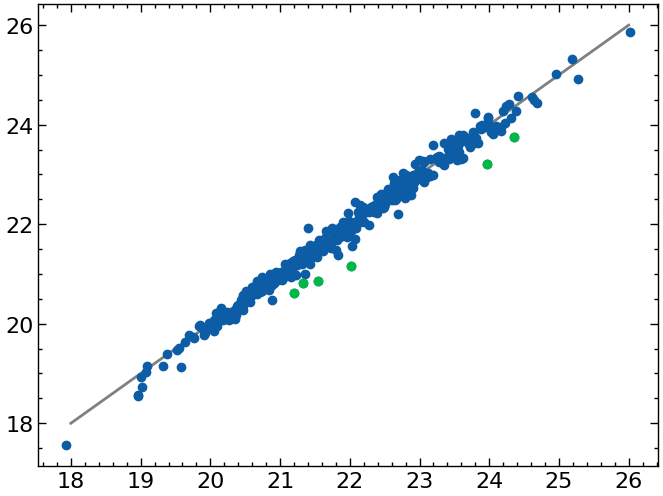

In [149]:
plt.scatter(data_cosmos2020j['HSC_i_MAG'][idx_COSMOS20], data_agn['i-mag'][idx_agn2COSMOS20])
dm = data_cosmos2020j['HSC_i_MAG'][idx_COSMOS20] - data_agn['i-mag'][idx_agn2COSMOS20] < 0.5
print(len(idx_COSMOS20[dm]))
plt.scatter(data_cosmos2020j['HSC_i_MAG'][idx_COSMOS20][~dm], data_agn['i-mag'][idx_agn2COSMOS20][~dm])

plt.plot([18, 26], [18, 26], color='gray', zorder=-1)

In [150]:
# Fix up the X-ray fluxes:
# This doesn't really do anything except reformat the columns

data_cosmos2020j['CHANDRA_FLUXERR'].data.data[data_cosmos2020j['CHANDRA_FLUXERR']=='---'] = -999
data_cosmos2020j['CHANDRA_FLUXERR'] = np.ma.masked_array(data_cosmos2020j['CHANDRA_FLUXERR'].data.data.astype(float))
# Units at 4 KeV
data_cosmos2020j['CHANDRA_FLUX'] = np.ma.masked_array(data_cosmos2020j['CHANDRA_FLUX'].data.data*(1*u.mW/(u.m**2*9.671e17*u.Hz)).to(u.uJy).value)
data_cosmos2020j['CHANDRA_FLUXERR'] = np.ma.masked_array(data_cosmos2020j['CHANDRA_FLUXERR'].data.data*(1*u.mW/(u.m**2*9.671e17*u.Hz)).to(u.uJy).value)

### Add updated photo-z to the table

In [151]:





# mask_spec = data_agn['r_z'] < 2 # 1 (SIMBAD spec-z) or 0 (PDR3 spec-z)
# # Get photo-z from COSMOS
# #idx_agn2COSMOS20_ph, idx_COSMOS20_ph, d2d, d3d = cat_COSMOS2020.search_around_sky(cat_agn, 0.5*u.arcsec)

# #data_agn[~mask_spec] = data_cosmos2020j[idx_COSMOS20_ph]
# print(data_agn[~mask_spec])
# #data_agn.write('hsc_agn_updated_ph.txt', format='ascii', overwrite=True)

 ID   RAdeg    DEdeg  i-mag X-flag ... z-flag n-corr   z   r_z ID-COSMOS2015
 --    deg      deg    mag    --   ...   --     --     --   --       --     
--- --------- ------- ----- ------ ... ------ ------ ----- --- -------------
  1 150.74386 2.20245 22.71      1 ...      1      6 1.561   3        594392
  9 150.71391 1.97214 22.87      1 ...      1      5 1.474   3        445280
 10 150.63146 2.00264 23.26      1 ...      1      6 1.826   2        463657
 13 150.68274 2.08403 20.72      1 ...      1      5 1.234   3        516177
 14  150.5845 2.02168 23.28      1 ...      1      6  1.91   3        475665
 25 150.63844 2.39134 22.56      1 ...      1      6 3.649   3        720289
 27 150.55556 2.36917 23.29      1 ...      1      6 1.634   2        706553
 29 150.56727 2.50359 21.03      1 ...      1      6 1.146   3        794377
 30 150.61728 2.48275 22.59      1 ...      1      6 2.735   3        779775
 38 150.62846 2.67745 23.05      1 ...      1      6 2.225   3        907047

### Photo-z comparison

Lephare includes AGN component. Even then, the photo-z's are rough

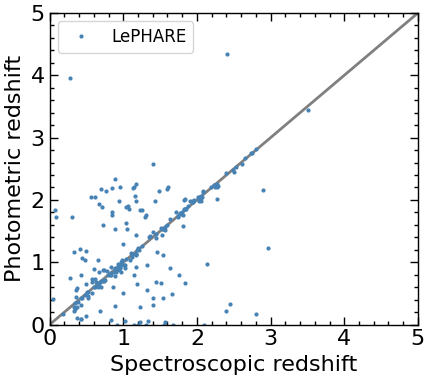

In [154]:
z_hsc = data_agn['z'][idx_agn2COSMOS20]

z_agn = data_cosmos2020j['lp_zq'][idx_COSMOS20]

mask_spec = data_agn['r_z'][idx_agn2COSMOS20] < 2

fig, ax = plt.subplots(1,1, figsize=(4.5, 4))

ax.errorbar(z_hsc[mask_spec], z_agn[mask_spec], color='steelblue',
            marker='.', ms=4, linestyle='none', label='LePHARE')

ax.set_xlabel('Spectroscopic redshift')
ax.set_ylabel('Photometric redshift')


ax.legend(frameon=True, fontsize=12)
ax.plot([-1, 5], [-1, 5], color='gray', zorder=-1)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

fig.tight_layout()
fig.savefig('photoz.pdf', dpi=300)

In [161]:
data_agn_updated['z3'] = -1. 

data_agn_updated['z3'][idx_agn2COSMOS20] = data_cosmos2020j['lp_zq'][idx_COSMOS20]
data_agn_updated['z3'][~np.isfinite(data_agn_updated['z3'])] = -1.

# z_cosmos = data_cosmos2020j['lp_zq'][idx_COSMOS20]
# z_cosmos[~np.isfinite(z_cosmos)] = -1.0

# data_agn['z_spec'] = -1.0
# data_agn['z_spec'][idx_agn2COSMOS20] = data_cosmos2020j['lp_zq'][idx_COSMOS20]
# data_agn['z'][data_agn['r_z']>1] = data_agn['z_spec'][data_agn['r_z']>1]
# data_agn['r_z'][data_agn['r_z']>1] = 2 # COSMOS2020 photo-z

# data_agn.write('hsc_agn_updated_specz.txt', format='ascii', overwrite=True)

Some of these spec-z's are wrong so careful there

### Compile the results above

Visually check our data completeness

(-10.0, 51.0)

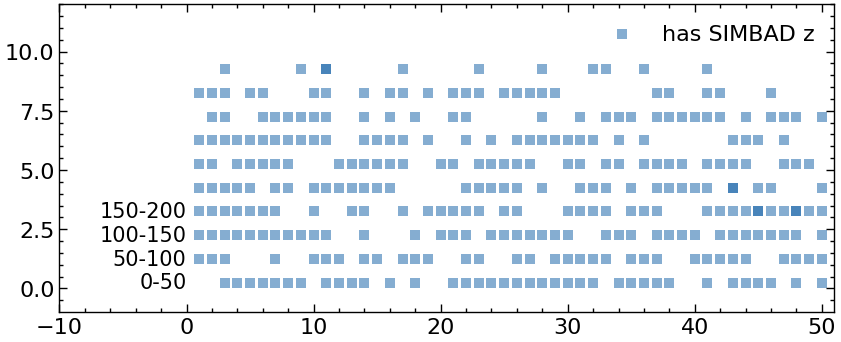

In [ ]:
ID = result_table['SCRIPT_NUMBER_ID']

plt.figure(figsize=[10, 4])

# mask_simbad = 
plt.scatter((ID%50+1)[mask_spec_simbad], (ID//50+0.25)[mask_spec_simbad], linewidths=0, alpha=0.5, s=50, marker='s', label='has a SIMBAD z')
plt.scatter((ID%50+1)[mask_spec_simbad], (ID//50+0.25)[mask_spec_simbad], linewidths=0, alpha=0.5, s=50, marker='s', label='has a SIMBAD z')

# plt.grid()
plt.legend()
plt.text(-0, 0, '0-50', size=15, ha='right')
plt.text(-0, 1, '50-100', size=15, ha='right')
plt.text(-0, 2, '100-150', size=15, ha='right')
plt.text(-0, 3, '150-200', size=15, ha='right')
plt.ylim(-1, 12)
plt.xlim(-10, 51)

In [ ]:
unq, unq_idx, unq_cnt = np.unique(result_table['SCRIPT_NUMBER_ID'], return_inverse=True, return_counts=True)

# result_table['SCRIPT_NUMBER_ID'] #[unq_cnt>1]
len(unq_cnt)

489

### Visually check results

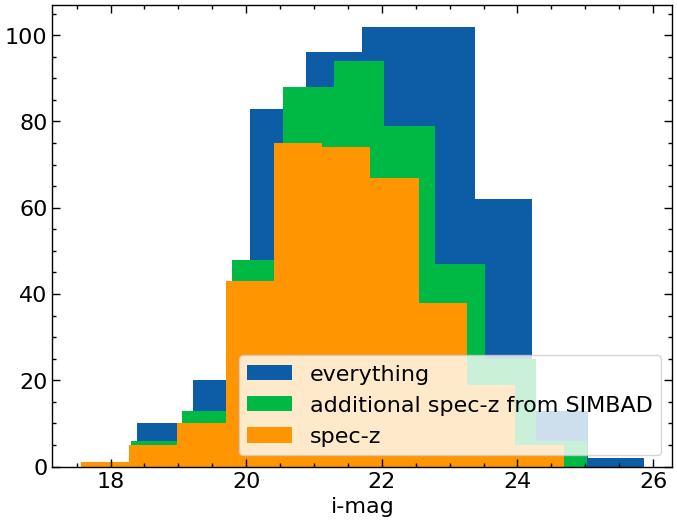

In [ ]:
mask_specz_updated = data_agn_updated['r_z'] < 3
plt.hist(data_agn_updated['i-mag'], label='everything')
plt.hist(data_agn_updated['i-mag'][mask_specz_updated], label='additional spec-z from SIMBAD')
mask_specz = data_agn['r_z'] < 3
plt.hist(data_agn['i-mag'][mask_specz], label='spec-z')
plt.xlabel('i-mag')
plt.legend(frameon=True, loc=4)

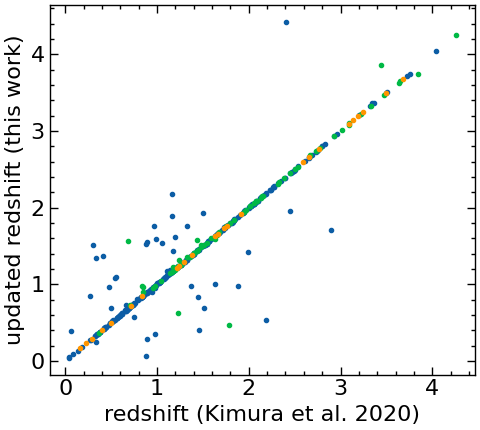

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5, 4.5))

mask_specz = data_agn['r_z'] < 3
ax.scatter(data_agn['z'][mask_specz], data_agn_updated['z'][mask_specz], 
           marker='.', label='spec-z')

mask_specz = (data_agn['r_z'] > 2) & (data_agn_updated['r_z'] < 3)
ax.scatter(data_agn['z'][mask_specz], data_agn_updated['z'][mask_specz],
           marker='.', label='Kimura photo-z -> updated with spec-z')

mask_specz = data_agn_updated['r_z'] > 3
ax.scatter(data_agn['z'][mask_specz], data_agn_updated['z'][mask_specz],
           marker='.', label='photo-z')

ax.set_xlabel('redshift (Kimura et al. 2020)')
ax.set_ylabel('updated redshift (this work)')
# ax.legend()
fig.tight_layout()
fig.savefig('specz.pdf', dpi=300)

Create a bar chart of where our data comes from

In [ ]:
# HSC (matched in HSC catalog)
hsc_sources = {}
for key in source_keys: 
    hsc_sources[key] = np.count_nonzero(hsc_targets[idx_hsc_pdr3][key])
hsc_sources_filtered = {key:value for key, value in zip(hsc_sources.keys(), hsc_sources.values()) if value!=0}

# simbad (others than above)
using_simbad_mask = [i not in idx_hsc_specz for i in data_agn_updated['ID']-1]
bibcodes, _ = np.unique(data_agn_updated['bibcode'][using_simbad_mask], return_counts=True)
simbad_sources = {}
for key in bibcodes: 
    simbad_sources[key] = np.count_nonzero(data_agn_updated['bibcode'][using_simbad_mask]==key)

joint_source = {}
joint_source.update(hsc_sources_filtered)
joint_source.update(simbad_sources)
convert_bibcodes = { 
    'specz_flag_zcosmos_bright_dr3':['zCOSMOS DR3 (in HSC)',    'Y', '2009ApJS..184..218L', 'overestimate z'], 
    'specz_flag_3dhst_v4_1_5':      ['3D-HST v4.1.5 (in HSC)',  '?', '2016ApJS..225...27M', ''], 
    'specz_flag_sdss_dr15':         ['SDSS-DR15 (in HSC)',      'Y', '2020ApJS..249....3A', ''], 
    'specz_flag_c3r2_dr2':          ['C3R2 DR2 (in HSC)',       '?', '2017ApJ...841..111M', ''], 
    'specz_flag_vvds_drfinal':      ['VVDS DRFinal (in HSC)',   '?', '2013A&A...559A..14L', ''], 
    'specz_flag_deimos_2018':       ['DEIMOS (in HSC)',         'N', '2018ApJ...858...77H', 'no website'], 
    'specz_flag_fmos_dr2':          ['FMOS-COSMOS DR2 (in HSC)','?', '2015ApJS..220...12S', ''], 
    'specz_flag_lega_c_dr2':        ['LEGA-C DR2 (in HSC)',     '?', '2018ApJS..239...27S', ''], 
    'specz_flag_primus_dr1':        ['PRIMUS (in HSC)',         'N', '2013ApJ...767..118C', 'prism, underestimate z'], 
    '-------------------':          ['not specified',           '?', '-------------------', ''], 
    '2009ApJ...696.1195T':          ['Magellean/zCOSMOS',       'Y', '2009ApJ...696.1195T', ''], 
    '2015ApJS..220...12S':          ['2015ApJS..220...12S',     '?', '2015ApJS..220...12S', ''], 
    '2018ApJ...858...77H':          ['DEIMOS',                  'N', '2018ApJ...858...77H', 'spectra not available'], 
    '2018ApJ...869...20B':          ['2018ApJ...869...20B',     '?', '2018ApJ...869...20B', ''], 
    '2018ApJS..234...21D':          ['2018ApJS..234...21D',     '?', '2018ApJS..234...21D', ''], 
    '2018ApJS..239...27S':          ['2018ApJS..239...27S',     '?', '2018ApJS..239...27S', ''], 
    '2018PASJ...70S..10O':          ['2018PASJ...70S..10O',     '?', '2018PASJ...70S..10O', ''], 
    '2019ApJ...877...81M':          ['2019ApJ...877...81M',     '?', '2019ApJ...877...81M', ''], 
    '2020AJ....160...37M':          ['2020AJ....160...37M',     '?', '2020AJ....160...37M', ''], 
    '2020ApJ...894...24K':          ['Yuki K. (2020)',          'N', '2020ApJ...894...24K', 'HSC QSO catalog we used'], 
    '2021ApJS..256....9S':          ['2021ApJS..256....9S',     '?', '2021ApJS..256....9S', ''], 
    '2016ApJ...817...34M':          ['Chandra (may phot-z)',    '?', '2016ApJ...817...34M', ''], 
    '2016ApJS..224...24L':          ['COSMOS2015 (may phot-z)', '?', '2016ApJS..224...24L', '']}

# make a table
source_table = table.Table([[convert_bibcodes[key][0] for key in joint_source.keys()], 
                            list(joint_source.values()), 
                            [convert_bibcodes[key][1] for key in joint_source.keys()], 
                            [convert_bibcodes[key][2] for key in joint_source.keys()],
                            [convert_bibcodes[key][3] for key in joint_source.keys()], ], 
                           names=('source', 'count', 'availability', 'bibcode', 'comment'))
# TODO: complete this table
source_table

# # make a figure
# fig, ax = plt.subplots(1,1, figsize=(7, 6))
# ax.bar([key for key in joint_source.keys()], joint_source.values())
# for c in ax.containers:
#     ax.bar_label(c)
# plt.xticks(rotation=60, ha='right', rotation_mode='anchor');
# ax.set_ylabel('Number')
# fig.tight_layout()
# fig.savefig('specz_source.pdf', dpi=300); [convert_bibcodes[key] for key in joint_source.keys()]

source,count,availability,bibcode,comment
str24,int64,str1,str19,str23
zCOSMOS DR3 (in HSC),134,Y,2009ApJS..184..218L,overestimate z
3D-HST v4.1.5 (in HSC),14,?,2016ApJS..225...27M,
SDSS-DR15 (in HSC),45,Y,2020ApJS..249....3A,
C3R2 DR2 (in HSC),1,?,2017ApJ...841..111M,
VVDS DRFinal (in HSC),2,?,2013A&A...559A..14L,
DEIMOS (in HSC),78,N,2018ApJ...858...77H,no website
FMOS-COSMOS DR2 (in HSC),35,?,2015ApJS..220...12S,
LEGA-C DR2 (in HSC),6,?,2018ApJS..239...27S,
PRIMUS (in HSC),64,N,2013ApJ...767..118C,"prism, underestimate z"


### Visually inspect the inconsistency

Check if SIMBAD spec-z and paper spec-z are consistent

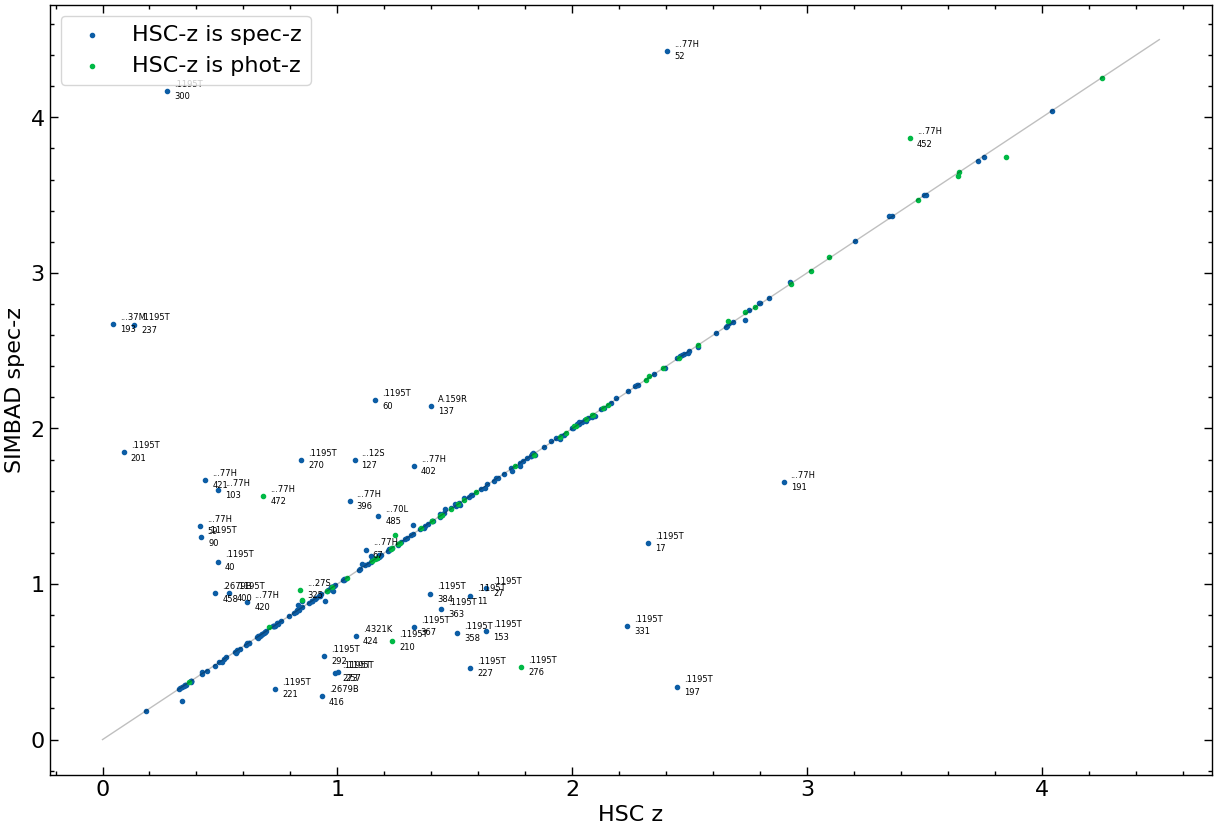

In [ ]:
data_agn_compare = table.Table(data=[[0.]*491, ['none']*491, [0.]*491, ['-'*19]*491, [None]*491], 
                               names=['HSC-z', 'r_HSC-z', 'SIMBAD-z', 'bib_SIMBAD-z', 'name'])
for j,i in enumerate(idx_simbad_specz):
    if data_agn['r_z'][i] <= 2:
        data_agn_compare['r_HSC-z'][i] = 'spec'
    else: 
        data_agn_compare['r_HSC-z'][i] = 'phot'
    data_agn_compare['HSC-z'][i] = data_agn['z'][i]
    data_agn_compare['SIMBAD-z'][i] = result_table[mask_spec_simbad]['Z_VALUE'][j]
    data_agn_compare['bib_SIMBAD-z'][i] = result_table[mask_spec_simbad]['RVZ_BIBCODE'][j]
    data_agn_compare['name'][i] = result_table[mask_spec_simbad]['MAIN_ID'][j]

plt.figure(figsize=[15, 10])

plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='spec'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], 
            marker='.', label='HSC-z is spec-z')
plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='phot'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='phot'], 
            marker='.', label='HSC-z is phot-z')
# add bibcode to interested dots
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if (np.abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1) : 
        plt.annotate(txt[13:], (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]+0.03), size=6)
        plt.annotate(i+1, (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]-0.05), size=6)
plt.plot([0, 4.5], [0, 4.5], '-k', linewidth=1, alpha=0.25)
plt.xlabel('HSC z')
plt.ylabel('SIMBAD spec-z')
plt.legend(frameon=True)
plt.show()

data_agn_compare.write('hsc_agn_compare.txt', format='ascii', overwrite=True)

generate a list of inconsistent values

In [ ]:
inconsistent_list = []
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1 \
       and data_agn_compare['r_HSC-z'][i]=='spec': 
        inconsistent_list.append(i+1)
inconsistent_list = np.array(inconsistent_list)

data_agn_inconsistent = data_agn_updated[inconsistent_list-1]

# for data in data_agn_inconsistent: 
#     print('    OR  abs(specz_ra - %9.5f) < 0.001 AND abs(specz_dec - %7.5f) < 0.001'%(data['RAdeg'], data['DEdeg']))

data_agn_inconsistent 


ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
--,deg,deg,mag,--,--,--,--,--,--,--,--,--,
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
11,150.66094,1.97536,21.47,1,1,1,1,1,6,1.5652,1,448411,2020ApJ...894...24K
17,150.55903,2.10576,22.61,1,1,1,1,1,6,2.3219,1,529336,2020ApJ...894...24K
27,150.55556,2.36917,23.29,1,1,1,1,1,6,1.634,1,706553,2018ApJ...858...77H
40,150.55588,2.56438,21.89,1,1,1,1,1,6,0.4924,1,834538,2020ApJ...894...24K
52,150.48562,1.87193,22.23,1,1,1,1,1,6,4.426,1,382203,2020ApJ...894...24K
59,150.35262,1.93201,22.77,1,1,1,1,1,6,1.373,1,420196,2020ApJ...894...24K
60,150.43102,1.93527,21.47,1,1,1,1,1,6,2.177,1,422734,2020ApJ...894...24K
67,150.41577,1.9678,22.7,1,1,1,1,1,6,1.121,1,443133,2020ApJ...894...24K


### Check with i-magnitude

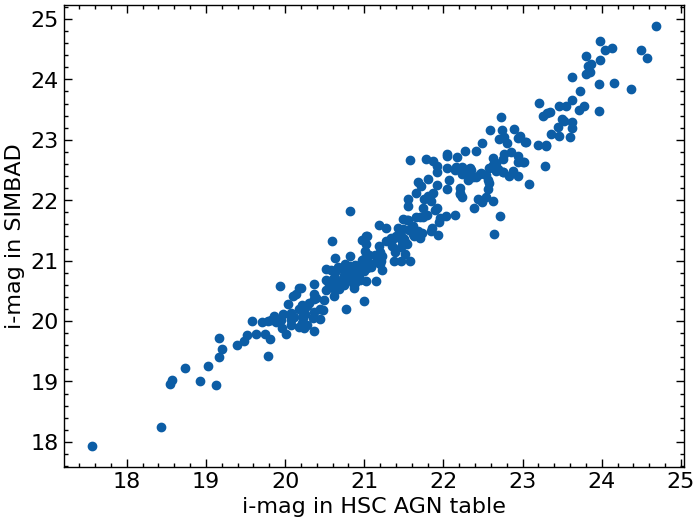

In [ ]:
plt.scatter(data_agn['i-mag'][idx_simbad_specz], result_table['FLUX_i'][mask_spec_simbad])
plt.xlabel('i-mag in HSC AGN table')
plt.ylabel('i-mag in SIMBAD');

In [145]:


data_agn_updated.write('hsc_agn_updated.txt', format='ascii', overwrite=True)

data_agn_updated

ID,RAdeg,DEdeg,z_old,r_z_old,z,r_z,z2,z1,z1_ref,z0,z0_ref
--,deg,deg,--,--,,,,,,,
int64,float64,float64,float64,int64,float64,int64,float64,float64,object,float64,object
1,150.74386,2.20245,1.561,3,-1.0,-1,-1.0,-1.0,None,-1.0,None
2,150.73557,2.19957,3.499,1,-1.0,-1,-1.0,3.503096,3dhst_v4_1_5,3.5026,2014A&A...563A..54P
3,150.73353,2.15646,0.977,1,-1.0,-1,-1.0,0.9769,3dhst_v4_1_5,0.979,2009ApJ...696.1195T
4,150.79702,2.13888,0.573,1,-1.0,-1,-1.0,0.5727,3dhst_v4_1_5,0.5727,2018A&A...611A..53J
5,150.78259,2.19306,0.585,1,-1.0,-1,-1.0,0.5847,3dhst_v4_1_5,0.5824,2009ApJ...696.1195T
6,150.72019,2.24803,0.664,1,-1.0,-1,-1.0,0.6633,3dhst_v4_1_5,0.6652,2009ApJ...696.1195T
7,150.78838,2.34399,1.964,1,-1.0,-1,-1.0,1.964449,3dhst_v4_1_5,1.9555,2009ApJ...696.1195T
8,150.71511,2.48483,1.999,1,-1.0,-1,-1.0,1.995,3dhst_v4_1_5,2.0051,2009ApJ...696.1195T
